In [1]:
import pandas as pd
import numpy as np

# import three files, takes very long
df_all = pd.read_csv('criteo-uplift-v2.1.csv')
df_treated = df_all[df_all.treatment == 1] #pd.read_csv('criteo_treated.csv', encoding='latin_1')
df_untreated = df_all[df_all.treatment == 0] #pd.read_csv('criteo_not_treated.csv', encoding='latin_1')

df_all.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')

In [2]:
#These are the number of rows in each file. Treated and Untreated data were extracted from the total data.
count_all = df_all['conversion'].count()
count_treated = df_treated['conversion'].count()
count_untreated = df_untreated['conversion'].count()
print(count_all,count_treated,count_untreated)

13979592 11882655 2096937


In [8]:
#conversion rate
print('conversion rate:', df_all.conversion[df_all.conversion == 1].count()/count_all)
print('conversion rate:', df_treated.conversion[df_all.conversion == 1].count()/count_treated)
print('conversion rate:', df_untreated.conversion[df_untreated.conversion == 1].count()/count_untreated)

conversion rate: 0.002916680257907384
conversion rate: 0.0030894610674129645
conversion rate: 0.0019375880152813366


#### By the number of untreated data, select these numbers of data randomly from all/treated/untreated
* 60% train = 1258163
* 20% validation = 419387
* 20% test = 419387
#### To do this, I shuffle each dataset and choose corresponding number of rows from them, so that we are in fact randomly selecting our training, validating and testing set

In [9]:
#Shuffle data to make sure random selection
from sklearn.utils import shuffle
df_untreated = shuffle(df_untreated)
df_treated = shuffle(df_treated)
df_all = shuffle(df_all)

In [10]:
#Set the number of train, validation and test data we want to use
train = 1258163   
val = 419387
test = 419387
learn = train

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

features = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']
def build_classifier(df, dependent_variable,learn):
    #print(dependent_variable)
    X, y = df[features][:learn], df[dependent_variable][:learn] #learning set is learn, validation set is train always
    X_val, y_val = df[features][train:train+val], df[dependent_variable][train:train+val]
    # If we use the default solver, the model does not converge
    clf = inner_cv(X, y)
    #print(f"Accuracy: {clf.score(X_val, y_val)}")
    fpr, tpr, thresholds = metrics.roc_curve(y_val, clf.predict_proba(X_val)[:,1])
    #print(f"AUC: {metrics.auc(fpr, tpr)}")
    return clf
def build_classifier_regression(df, dependent_variable,learn):
    #print(dependent_variable)
    X, y = df[features][:learn], df[dependent_variable][:learn] #learning set is learn, validation set is train always
    X_val, y_val = df[features][train:train+val], df[dependent_variable][train:train+val]
    # If we use the default solver, the model does not converge
    clf = DecisionTreeRegressor(min_samples_leaf = 10000).fit(X, y)
    #print(f"Accuracy: {clf.score(X_val, y_val)}")
    #fpr, tpr, thresholds = metrics.roc_curve(y_val, clf.predict_proba(X_val)[:,1])
    #print(f"AUC: {metrics.auc(fpr, tpr)}")
    return clf

## Model 1: All data, predict conversion

In [ ]:
#Model 1: run logistic regression for all data (including treated and untreated) to predict conversion
clf_all = build_classifier(df_all, 'conversion',learn)

## Model 2: All data, predict visit

In [10]:
#Model 2: run logistic regression for all data (including treated and untreated) to predict visit
clf_all_visit = build_classifier(df_all, 'visit',learn)

Accuracy: 0.9581198272717085
AUC: 0.9441745327072171


## Model 3: Treated data, predict conversion

In [11]:
clf_treated = build_classifier(df_treated, 'conversion',learn)

Accuracy: 0.9968978532954049
AUC: 0.9265413162092733


## Model 4: Treated data, predict visit

In [12]:
clf_treated_visit = build_classifier(df_treated, 'visit',learn)

Accuracy: 0.9569729152310396
AUC: 0.9422483336004015


## Model 5: Untreated data, predict conversion

In [13]:
clf_untreated = build_classifier(df_untreated, 'conversion',learn)

Accuracy: 0.9980495342011078
AUC: 0.9161715579419064


## Model 6: Untreated data, predict visit

In [14]:
clf_untreated_visit = build_classifier(df_untreated, 'visit',learn)

Accuracy: 0.9644862620920533
AUC: 0.943784283729276


## Model 1 Prediction
### After building the models, we do evaluation and prediction using validation data
* some data in val_set might be the same with training data in untreated/treated data set
* val_set is completely separated from training data of model 1

In [15]:
val_set = df_all[train:train+val]

## Now we see the features of the validation set

In [16]:
#porportion of people treated
targeted = val_set.treatment.mean()
targeted

0.849556614773467

In [17]:
#conversion rate on treated
treat_all = val_set[val_set.treatment == 1].conversion.mean()
treat_all

0.0032866208429579028

In [18]:
#conversion rate on not treated
treat_none = val_set[val_set.treatment == 0].conversion.mean()
treat_none

0.0022189114654325294

In [19]:
#conversion rate if treat randomly (according to the percentage treated)
treat_random = treat_all*targeted+treat_none*(1-targeted)
treat_random

0.0031259910297648714

## Now, we target top 10% and see the result

In [74]:
def do_targeting(scores, val_set):
    results = val_set[['treatment', 'conversion']].copy()
    # Do the targeting
    target_size = 41939 #10%
    bottom_score = np.sort(scores)[-target_size]
    results['target_decision'] = (scores >= bottom_score).astype(int)
    # Estimate rewards
    matches = results.target_decision == results.treatment.values
    treatment_rate = val_set.treatment.mean()
    weights = results.treatment * treatment_rate + (1 - results.treatment) * (1 - treatment_rate)
    results['reward'] = val_set.conversion.values * matches / weights
    return results

all_scores = clf_all.predict_proba(val_set[features])[:, 1]
m1 = do_targeting(all_scores, val_set)
m1.reward.value_counts()

0.000000    418349
1.177085      1020
6.647019        18
Name: reward, dtype: int64

In [75]:
#calculte effects
def effect(m):
    treat_with_model = m.reward.mean()
    for_target_treated = m[m.target_decision * m.treatment == 1].conversion.mean()
    for_target_untreated = m[m.target_decision * (1-m.treatment) == 1].conversion.mean()
    avg_effect = treat_all-treat_none
    effect_for_targeted = for_target_treated - for_target_untreated
    return treat_with_model,for_target_treated,for_target_untreated,avg_effect,effect_for_targeted

effect1 = effect(m1)
effect1

(0.003148100965248143,
 0.028082154066406035,
 0.02058029689608637,
 0.0010677093775253734,
 0.007501857170319665)

## Model 3 Prediction 

In [76]:
tr_scores = clf_treated.predict_proba(val_set[features])[:, 1]
m3 = do_targeting(tr_scores, val_set)
m3.reward.value_counts()

0.000000    418331
1.177085      1034
6.647019        22
Name: reward, dtype: int64

In [77]:
effect3 = effect(m3)
effect3

(0.003250791938508392,
 0.028679998890522286,
 0.019772117962466487,
 0.0010677093775253734,
 0.008907880928055799)

## Model 5 Prediction

In [78]:
un_scores = clf_untreated.predict_proba(val_set[features])[:, 1]
m5 = do_targeting(un_scores, val_set)
m5.reward.value_counts()

0.000000    418359
1.177085      1012
6.647019        16
Name: reward, dtype: int64

In [79]:
effect5 = effect(m5)
effect5

(0.0030939487998452118,
 0.028086145648312612,
 0.020635713097021134,
 0.0010677093775253734,
 0.007450432551291478)

## Uplift Prediction
* Create an uplift model by using prediction of treated - untreated

In [80]:
up_scores = tr_scores - un_scores
up = do_targeting(up_scores, val_set)
up.reward.value_counts()

0.000000    418587
1.177085       732
6.647019        68
Name: reward, dtype: int64

In [81]:
effect_up = effect(up)
effect_up

(0.003132245859191119,
 0.02029612377308268,
 0.012050209205020921,
 0.0010677093775253734,
 0.008245914568061759)

### Use Spearman correlation to see how closely these models are ranking things

In [82]:
from scipy import stats
stats.spearmanr(all_scores, tr_scores)

SpearmanrResult(correlation=0.5453897170826714, pvalue=0.0)

In [83]:
stats.spearmanr(all_scores, un_scores)

SpearmanrResult(correlation=0.4973211516661934, pvalue=0.0)

In [84]:
stats.spearmanr(tr_scores, un_scores)

SpearmanrResult(correlation=0.48797302909288126, pvalue=0.0)

In [85]:
stats.spearmanr(all_scores, up_scores)

SpearmanrResult(correlation=0.21815640306150236, pvalue=0.0)

In [86]:
stats.spearmanr(tr_scores, up_scores)

SpearmanrResult(correlation=0.6358338140485239, pvalue=0.0)

In [87]:
stats.spearmanr(un_scores, up_scores)

SpearmanrResult(correlation=-0.16603803515481555, pvalue=0.0)

## Summarize effect for models

In [88]:
result = pd.DataFrame(np.array([np.array(effect1),np.array(effect3),np.array(effect5),np.array(effect_up)]),index = ['model_all','model_treated','model_untreated','uplift'],columns = ['treat_with_model','for_target_treated','for_target_untreated','avg_effect','effect_for_targeted'])
result

,treat_with_model,for_target_treated,for_target_untreated,avg_effect,effect_for_targeted
model_all,0.003148,0.028082,0.020580,0.001068,0.007502
model_treated,0.003251,0.028680,0.019772,0.001068,0.008908
model_untreated,0.003094,0.028086,0.020636,0.001068,0.007450
uplift,0.003132,0.020296,0.012050,0.001068,0.008246


## Learning curve 12.20

In [39]:
def auc(model,dependent_variable):
    fpr, tpr, thresholds = metrics.roc_curve(val_set[dependent_variable], model.predict_proba(val_set[features])[:,1])
    return metrics.auc(fpr, tpr)
def auc_up(model_tr,model_un,dependent_variable):
    fpr, tpr, thresholds = metrics.roc_curve(val_set[dependent_variable], model_tr.predict_proba(val_set[features])[:,1]-model_un.predict_proba(val_set[features])[:,1])
    return metrics.auc(fpr, tpr)
def auc_x(model0,model1,dependent_variable):
    fpr, tpr, thresholds = metrics.roc_curve(val_set[dependent_variable], model0.predict(val_set[features])*(1-targeted)+model1.predict(val_set[features])*(targeted))
    return metrics.auc(fpr, tpr)

In [40]:
def reward(model):
    all_scores = model.predict_proba(val_set[features])[:, 1]
    m_temp = do_targeting(all_scores, val_set)
    return effect(m_temp)[0],effect(m_temp)[-1]
def reward_up(model_tr,model_un):
    all_scores = model_tr.predict_proba(val_set[features])[:, 1]-model_un.predict_proba(val_set[features])[:, 1]
    m_temp = do_targeting(all_scores, val_set)
    return effect(m_temp)[0],effect(m_temp)[-1],all_scores
def reward_x(model_tr,model_un):
    all_scores = model0.predict(val_set[features])*(1-targeted)+model1.predict(val_set[features])*(targeted)
    m_temp = do_targeting(all_scores, val_set)
    return effect(m_temp)[0],effect(m_temp)[-1]
#reward, effect_for_targeted
# number of positives as a f of score percentile for uplift, large dataset before jump +tiny dataset (not powerful) model, same distribution?



### Model 1: All data, conversion

In [ ]:
prct = [0.01,0.05,0.1,0.2,0.3,0.4,0.5]

In [90]:
auc_score = []
reward_score = []
effect_score = []
for l in prct:
    model = build_classifier(df_all, 'conversion',l*len(df_all))
    auc_score.append(auc(model,'conversion'))
    reward_score.append(reward(model)[0])
    effect_score.append(reward(model)[1])

In [44]:
import matplotlib.pyplot as plt
def draw_learning(reward_score,effect_score,a,b,step):
    x = [i for i in range(a,b,step)]
    plt.plot(x, reward_score,label = 'reward')
    #plt.plot(x, auc_score,label = 'auc_score')
    plt.plot(x, effect_score, label = 'effect on targeted')
    plt.xscale('log')
    plt.xlabel('# of train data')
    plt.ylabel('evaluation score')
    plt.legend()
def draw_learning_auc(auc_score,a,b,step):
    x = [i for i in range(a,b,step)]
    #plt.plot(x, reward_score,label = 'reward_score')
    plt.plot(x, auc_score,label = 'auc_score')
    #plt.plot(x, effect_score, label = 'effect_score')
    plt.xscale('log')
    plt.xlabel('# of train data')
    plt.ylabel('AUC score')
    plt.legend()

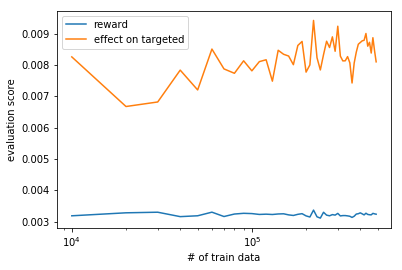

In [45]:
draw_learning(reward_score,effect_score,10000,500000,10000)

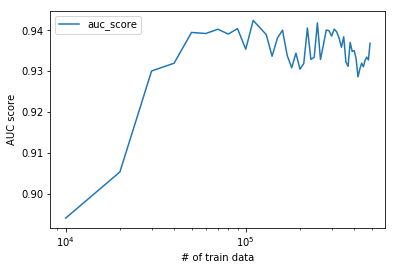

In [46]:
draw_learning_auc(auc_score,10000,500000,10000)

### AUC stops increasing at 100,000
### reward is constant at 0.003
### effect on targeted is around 0.004

In [61]:
#reward_score1 = []
#effect_score1 = []
#for l in range(1000,train,10000):
    #model = build_classifier(df_all, 'conversion',l)
    #auc_score1.append(auc(model,'conversion'))
    #reward_score1.append(reward(model)[0])
    #effect_score1.append(reward(model)[1])

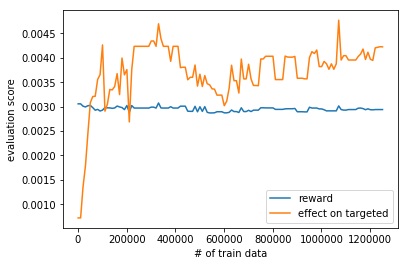

In [60]:
draw_learning(reward_score1,effect_score1,1000,train,10000)

### Model 1: 
* AUC around 0.91 to 0.95 when # of train data >= 100,000
* reward constant around 0.3
* effect on targeted between (0.0030 to 0.0045)

## Model 3: Treated data, conversion

In [91]:
auc_score3 = []
reward_score3 = []
effect_score3 = []
for l in prct:
    model = build_classifier(df_treated, 'conversion',l*len(df_treated))
    auc_score3.append(auc(model,'conversion'))
    reward_score3.append(reward(model)[0])
    effect_score3.append(reward(model)[1])

In [92]:
#draw_learning(reward_score3,effect_score3,10000,500000,10000)

In [93]:
#draw_learning_auc(auc_score3,10000,500000,10000)

## Model 5: Treated data, conversion

In [94]:
auc_score5 = []
reward_score5 = []
effect_score5 = []
for l in prct:
    model = build_classifier(df_untreated, 'conversion',l*len(df_untreated))
    auc_score5.append(auc(model,'conversion'))
    reward_score5.append(reward(model)[0])
    effect_score5.append(reward(model)[1])

## Uplift (T-learner)

In [95]:
# start with all untreated, increase treated data
auc_score_up2 = []
reward_score_up2 = []
effect_score_up2 = []
model_un = build_classifier(df_untreated, 'conversion',0.5*len(df_untreated))########## constant untreated for now
for l in prct:
    model_tr = build_classifier(df_treated, 'conversion',l*len(df_treated))
   
    auc_score_up2.append(auc_up(model_tr,model_un,'conversion'))
    reward_score_up2.append(reward_up(model_tr,model_un)[0])
    effect_score_up2.append(reward_up(model_tr,model_un)[1])

In [96]:
# increase both treated and untreated data 10000,500000,10000
auc_score_up = []
reward_score_up = []
effect_score_up = []
for l in prct:
    model_tr = build_classifier(df_treated, 'conversion',l*len(df_untreated))
    model_un = build_classifier(df_untreated, 'conversion',l*len(df_untreated))########## constant untreated for now
    auc_score_up.append(auc_up(model_tr,model_un,'conversion'))
    reward_score_up.append(reward_up(model_tr,model_un)[0])
    effect_score_up.append(reward_up(model_tr,model_un)[1])

In [97]:
def compare(auc_score,auc_score3,auc_score5,auc_score_up,auc_score_up2,title):

    x = prct
    plt.plot(x, auc_score,label = 'All')
    plt.plot(x, auc_score3,label = 'Treated')
    plt.plot(x, auc_score5,label = 'Untreated')
    plt.plot(x, auc_score_up,label = 'Uplift(varying both)')
    plt.plot(x, auc_score_up2,label = 'Uplift(varying treated data)')
    
    plt.xscale('log')

    plt.xlabel('# of train data')
    plt.ylabel(title)
    plt.legend()

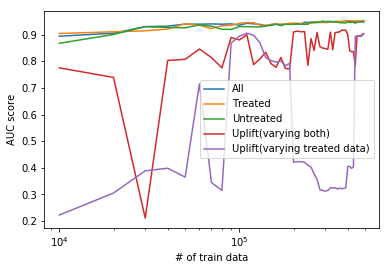

In [98]:
compare(auc_score,auc_score3,auc_score5,auc_score_up,auc_score_up2,'AUC score')

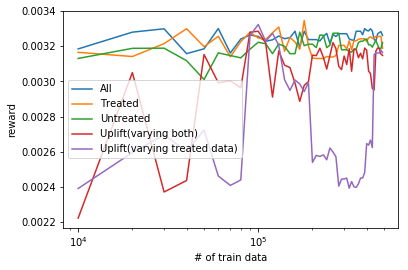

In [99]:
compare(reward_score,reward_score3,reward_score5,reward_score_up,reward_score_up2,'reward') ##### why is reward going down

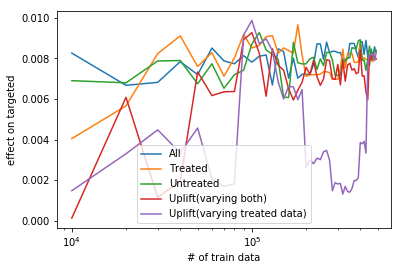

In [100]:
compare(effect_score,effect_score3,effect_score5,effect_score_up,effect_score_up2,'effect on targeted')

### 200,000

## X-learner

In [13]:
def x_learner(train):
    model_tr = build_classifier(df_treated, 'conversion',train)
    model_un = build_classifier(df_untreated, 'conversion',train)
    d1 = df_treated['conversion']-model_un.predict_proba(df_treated[features])[:, 1]
    d2 = model_tr.predict_proba(df_untreated[features])[:, 1]-df_untreated['conversion']
    df_d1 = df_treated[features]
    df_d2 = df_untreated[features]
    df_d1['d1'] = d1
    df_d2['d2'] = d2
    #print(df_d1.columns)
    model3 = build_classifier_regression(df_d1, 'd1',train) # what models to use for the second stage?
    model4 = build_classifier_regression(df_d2, 'd2',train)
    #0.85,0.15 (which one?)
    return model3, model4

In [16]:
x_learner0 = x_learner(10000)[0]
x_learner1 = x_learner(10000)[1]

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [80]:
auc_score_x = []
reward_score_x = []
effect_score_x = []
for l in range(10000,500000,10000):
    model0 = x_learner(l)[0]
    model1 = x_learner(l)[1]
   
    auc_score_x.append(auc_x(model0,model1,'conversion'))
    reward_score_x.append(reward_x(model0,model1)[0])
    effect_score_x.append(reward_x(model0,model1)[1])

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

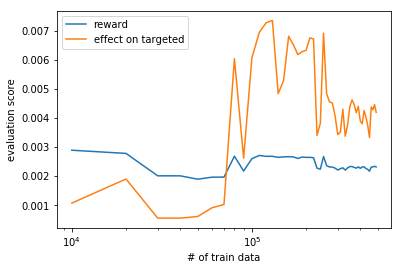

In [81]:
draw_learning(reward_score_x,effect_score_x,10000,500000,10000)

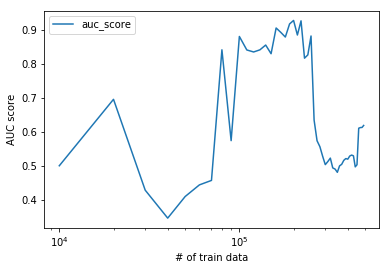

In [82]:
draw_learning_auc(auc_score_x,10000,500000,10000)

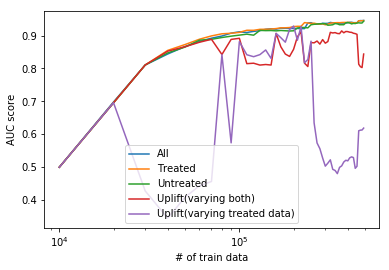

In [84]:
compare(auc_score,auc_score3,auc_score5,auc_score_up,auc_score_x, 'AUC score')

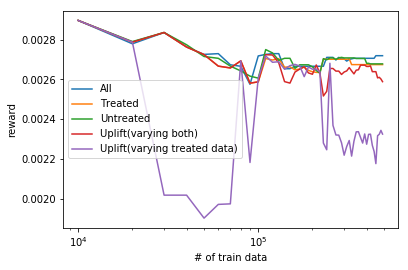

In [85]:
compare(reward_score,reward_score3,reward_score5,reward_score_up,reward_score_x,'reward')

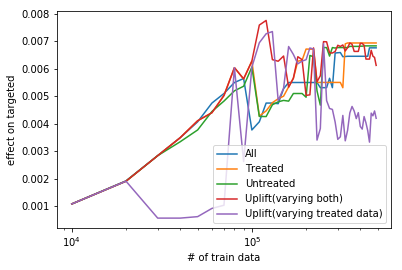

In [86]:
compare(effect_score,effect_score3,effect_score5,effect_score_up,effect_score_x,'effect on targeted')

### Nested cross validation

In [15]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


def inner_cv(X_train, y_train):
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = DecisionTreeClassifier(random_state=1)
    # define search space
    space = dict()
    a = 500000
    space['min_samples_split'] = [0.003,0.01,0.05,0.1,0.2,0.5]*a ########split 10,000 * percentage of positives?
    #space['max_features'] = [2, 4, 6]
    # define search
    search = GridSearchCV(model, space, scoring='roc_auc', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    return best_model

def inner_cv_regression(X_train, y_train):
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = DecisionTreeRegressor(random_state=1)
    # define search space
    space = dict()
    a = 500000
    space['min_samples_split'] = [0.003,0.01,0.05,0.1,0.2,0.3,0.4,0.5]*a
    #space['max_features'] = [2, 4, 6]
    # define search
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    return best_model
